# Mask Explorer

## Take a look at the Mask!

### What exactly is it, how was it made? 

Hello! And welcome to the MaskExplorer. Here we show off the mask that was made to separate Titan terrain into its various large-scale components and detail how it was made. While this notebook has a decent amount of code to display images, most of it doesn't do anything, as the notebook is not here to recreate the mask (that would be impossible anyway as many steps were don eby inspeciton). However, there is some code at the end that can ingest pixel information and plot where the pixels appear on the Titan map. 

So, let's begin!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..1500].


[Text(0, 0, '360'),
 Text(30, 0, '330'),
 Text(60, 0, '300'),
 Text(90, 0, '270'),
 Text(120, 0, '240'),
 Text(150, 0, '210'),
 Text(180, 0, '180'),
 Text(210, 0, '150'),
 Text(240, 0, '120'),
 Text(270, 0, '90'),
 Text(300, 0, '60'),
 Text(330, 0, '30'),
 Text(360, 0, '0')]

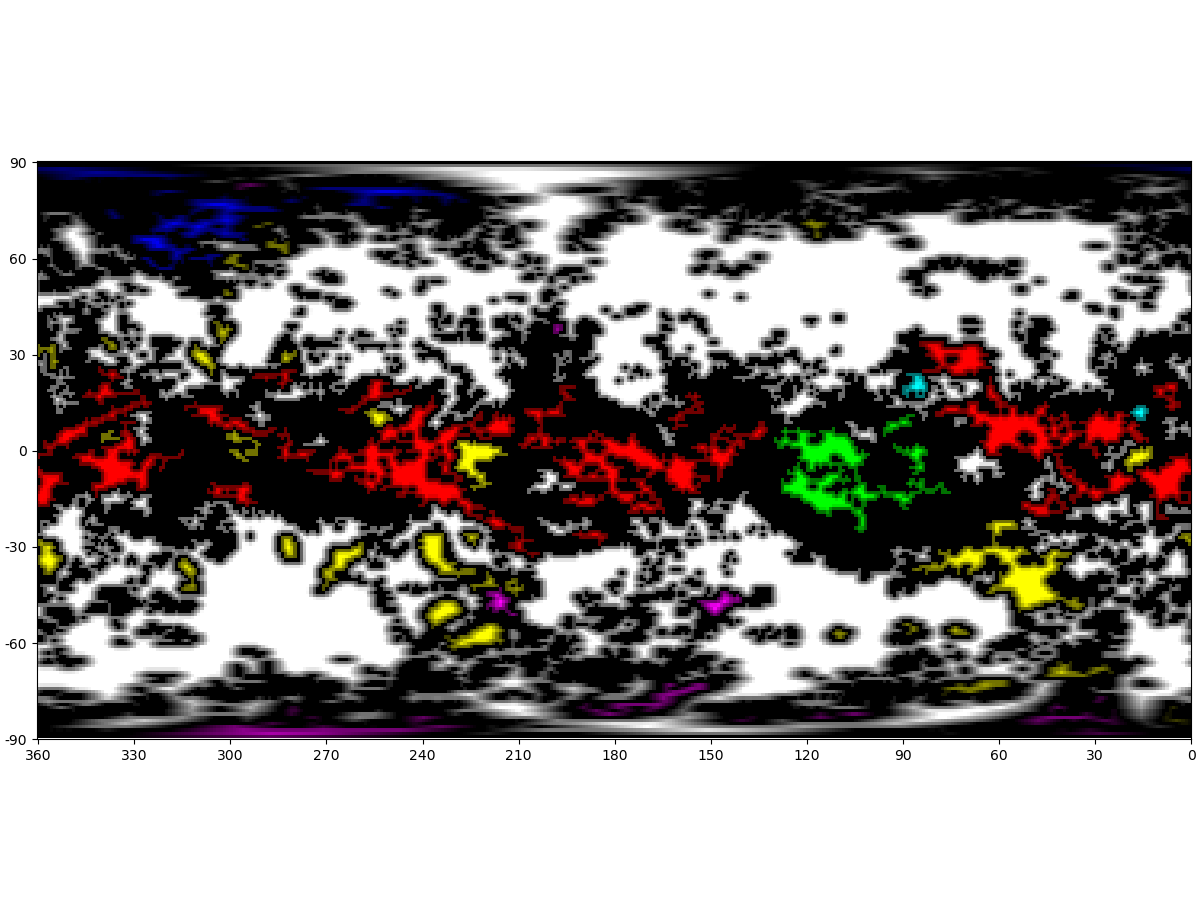

In [15]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

#Ticks
latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]
lonTicks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
lonLabels = ["360", "330", "300", "270", "240", "210", "180", "150", "120", "90", "60", "30", "0"]

#Displays the Mask
tester = np.load("CLRMaskArrayDist.npy")

plt.close()
fig, ax = plt.subplots(figsize = (12,9),layout="constrained")
image = ax.imshow(tester)
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)

This is the mask of Titan. 

Each pixel is 1 degree in width and length. 

Colors indicate what type of terrain is assigned to that pixel. White: Plains. Red: Dunes. Blue: Lakes. Yellow: Hummocky (mountainous). Magenta: Labyrinth. Green: Xanadu. Cyan: Crater. Black isn't so much a terrain type as an "no go zone" where we don't trust our identification of the terrain type; this is noted as "Null" in programs that care about it.

The brightness correlates to how close (in terms of km on the surface of Titan) the pixel is to a "Null" pixel, which is a rough measurement of how confident we are that the pixel is actually the terrain it's marked as. This information helps us figure out if we should accept pixels on certain cubes or not. For instnace, say we have a cube with 20km resolution, but it falls within a pixel that's only 5km away from a "Null" pixel. Obviously we throw that cube's data out as not necessarily reliable. Furthermore, VIMS pointing vectors are known to be off by significant amounts, so when automatically searching the entire database we only want to deal with pixels we are sufficiently confident in. The confidence values actually go to absurdly high levels, but we've cut them off here so the Plains don't dominate the visual appearance of the mask.

If we ignore the confidence values, the mask appears like so:

[Text(0.5, 1.0, 'Titan Surface Terrain Mask')]

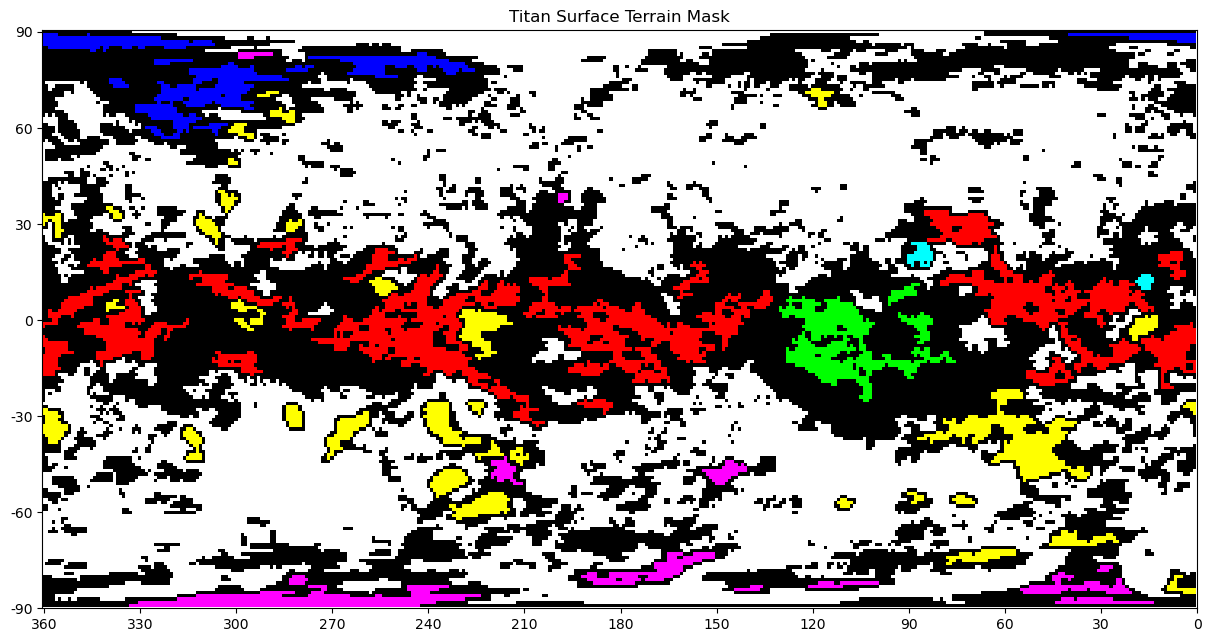

In [2]:
#Displays the Mask without Distance/Confidence
tester = np.load("CLRMaskArray.npy")

plt.close()
fig, ax = plt.subplots(figsize = (12,9),layout="constrained")
image = ax.imshow(tester)
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set(title = "Titan Surface Terrain Mask")

#plt.savefig("TitanSurfaceMask.pdf", format="pdf", bbox_inches='tight')

## How Was the Mask Made? 

The mask was made in the following manner. First, we took the terrain data from Lopes et al 2019, a terrain map made from radar data. (https://www.nature.com/articles/s41550-019-0917-6). Though this is behind a paywall, the figures have been spread around in various reports. (Bizarrely, PubMed has it, https://pubmed.ncbi.nlm.nih.gov/32500095/). 

The figure used to make this mask in question is the following:

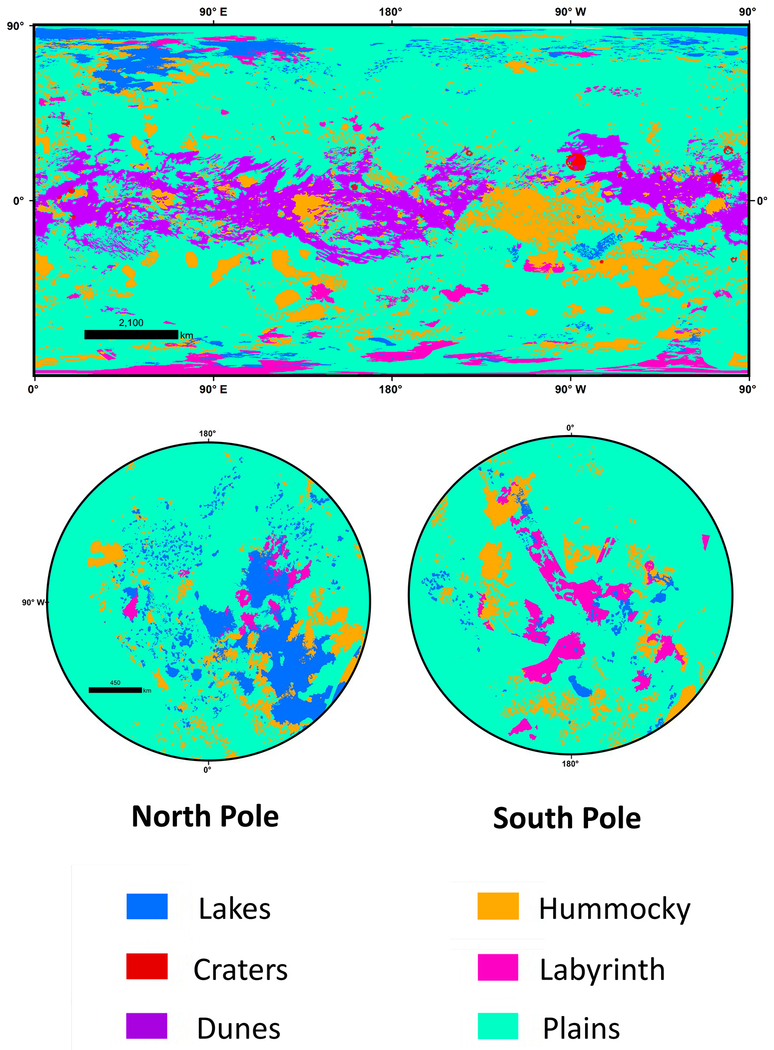

Only the top part of the figure was used. 


The map was then processed in the following way: 

1) Image processed to reduce the resolution of the top image to 1 pixel per degree, averaging nearby pixels.

2) Pixels that were not clearly single solid colors were marked as Null. This was done through a mixture of visual inspection and the very helpful paint bucket tool in Krita (a free photoshop-like program). We erred on the side of caution, more likely to assign Null than not.

3) Any pixels of different terrain types that were touching were both marked as Null, to avoid contamination.

4) The resulting map was compared with VIMS data to see if the results matched between Radar and IR imaging. There were some cases where VIMS was not able to assist: Plains, Hummocks, and Labyrinths look very similar to VIMS. However, VIMS was able to constrain the Dunes, and oust Southern Xanadu, Hotei Regio, and Tui Regio as particuarly different. All of these regions were blanket-marked as Null, as well as a few other areas that didn't match up across the Titan globe.

5) The rest of Xanadu thta was marked as Hummocky on the radar map was set aside as its own terrain type, as it is well known Xanadu behaves very differently from all other places on Titan. Unlike the Regios, Xanadu was justified in being given its own terrain type due to its massive size. Eastern Xanadu had too many Null pixels to receive many confident pixels.

6) Any tiny single-pixel islands or strings of pixels were makred Null.

7) The colors of the pixels were all adjusted to be easy to read computationally.

8) Distance was measured from every pixel to the nearest "Null" pixel through the horribly inefficient method of "check the distance to every single pixel on Titan." Slow, yes, but it only had to be done once. After this, the Mask was complete. 

Some in progres views of the mask:

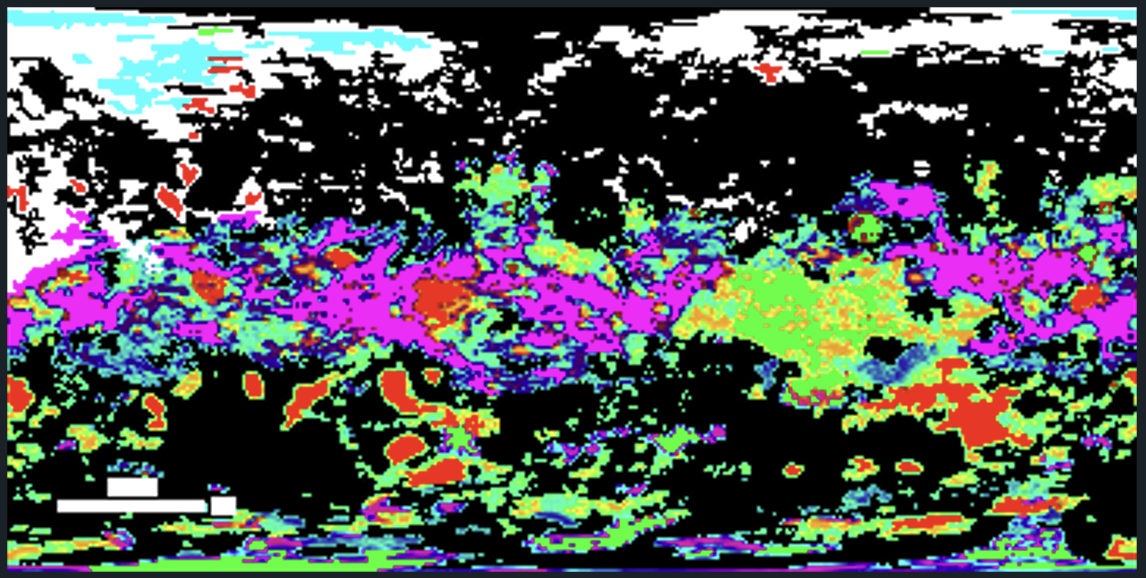

A version of the mask shortly after the original map's resolution was lowered. This snapshot is in the process of being cleaned up: the north pole's uncertain "Null" pixels have been found, but anything further south has not been fielded yet. Note that the colors do not match initial or final colors. They were changed later. 

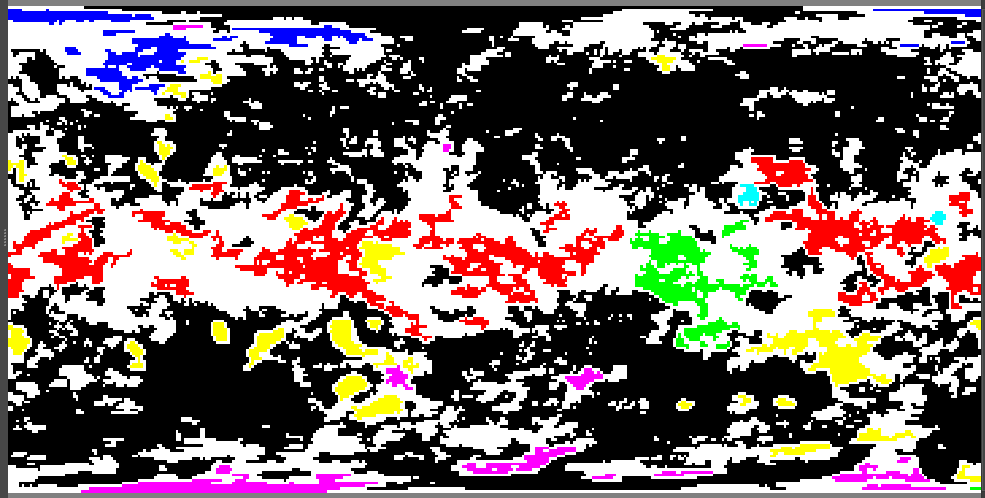

Here's one that's been more fully cleaned up, though note that southern Xanadu is still there, the Regios haven't been cleared out, and there are a few things that will be erased later. White and black were swapped later since having "Null" be "0 0 0" on the image made more sense.



How the computer reads the mask:

The computer has a pixel with a known lat and lon. It finds the locaiton on the mask that contains that lat and lon. If the computer is given no further restrictions, it'll record the terrian type based on color and continue on to the next pixel.

If it IS given restrictions, it will examine the pixel to see if it passes. Usually, this is a combination of "is it far enough from a Null pixel" and "is the distance to a Null pixel significantly larger than this pixel's resolution." Due to this a lot of the low-confidence and near-Null areas will be ignored. 

## Pixel Plotting

### For examining where pixels end up

Sometimes you want to know where on the mask was actually accepted. Well don't worry, we've got you covered. The next cell will read in a PixelFinder output file and take in various constraints, and then instead of creating a model it plots where the accepted pixels are. Code is veeeery similar to ModelCreator.

In [3]:
#PARAMETER SETTING
#Yes these are largely the same parameters you can set in ModelViewer. That's intentional. 
#This is where you tell the program what restrictions it should have on its observations.

inputFile = "northPolePixelResults.csv" #Shoudld be a "...PixelResults" file made by PixelFinder. Includes lots of pixel information.
inputFile = "..\\PixelFinder\\" + inputFile

ignoreNull = True #Usually you're ignoring Null values on the mask. If you're looking at a specific area and don't care, set this to False.

terrainType = "All" #Set to All if you want to have all of them. (Null is controlled separately via ignoreNull). Otherwise use "Lake" "Dunes" "Xanadu" "Crater" "Plains" "Hummocky" "Labyrinth" or "Null" but if you use "Null" make ignoreNull = False

#Set values you want to manage to True
#CAREFUL! Setting more than a couple options to True will produce a LOT of models. 

#No setting of wavelength: we don't care about I/F for this.

#The rest of these are usually False unless you're subdividing a model for some reason.

latLonCheck = True
flybyCheck = False #Temporal restriction by flyby number
resolutionCheck = True

maskDistCheck = True
maskDistResRelCheck = True

#Latlon
latUpperBound = 90.0
latLowerBound = 60.0
lonUpperBound = 360.0
lonLowerBound = 0.0

#Flyby
flybyUpperBound = "T120" #This is NOT inclusive, the upper bound here will NOT be kept. 
flybyLowerBound = "TA" #This IS inclusive, the lower bound here WILL be kept. 

#Resolution
resUpperBound = 25.0 #25.0 is considered standard. 
resLowerBound = 0.0

#Mask Stuff
#maskDistcheck
maskDistLimit = 50.0
#Only distances greater than this (km) will be accepted.

#maskDistresRelCheck
maskDistRelLimit = 1.0/4.0 # 1/4 is the standard one, meaning the distance to an untrusted pixel must be four times the pixel's resolution to pass judgment. 

#Things that are NOT sorted here:
#Cube coordinates, since there's no reason to sift via those, they just help you locate the pixel again later on. 
#Viewing Geometry Angles. The models we create want the largest range of these you can obtain for proper tetrahedralization.
#I/F of various windows, as restricting these values will create inacurate models at the end. 
#Cube number, as the flyby number gives enough of a time judgment for our purposes. 

[Text(0, 0, '90'),
 Text(0, 30, '60'),
 Text(0, 60, '30'),
 Text(0, 90, '0'),
 Text(0, 120, '-30'),
 Text(0, 150, '-60'),
 Text(0, 180, '-90')]

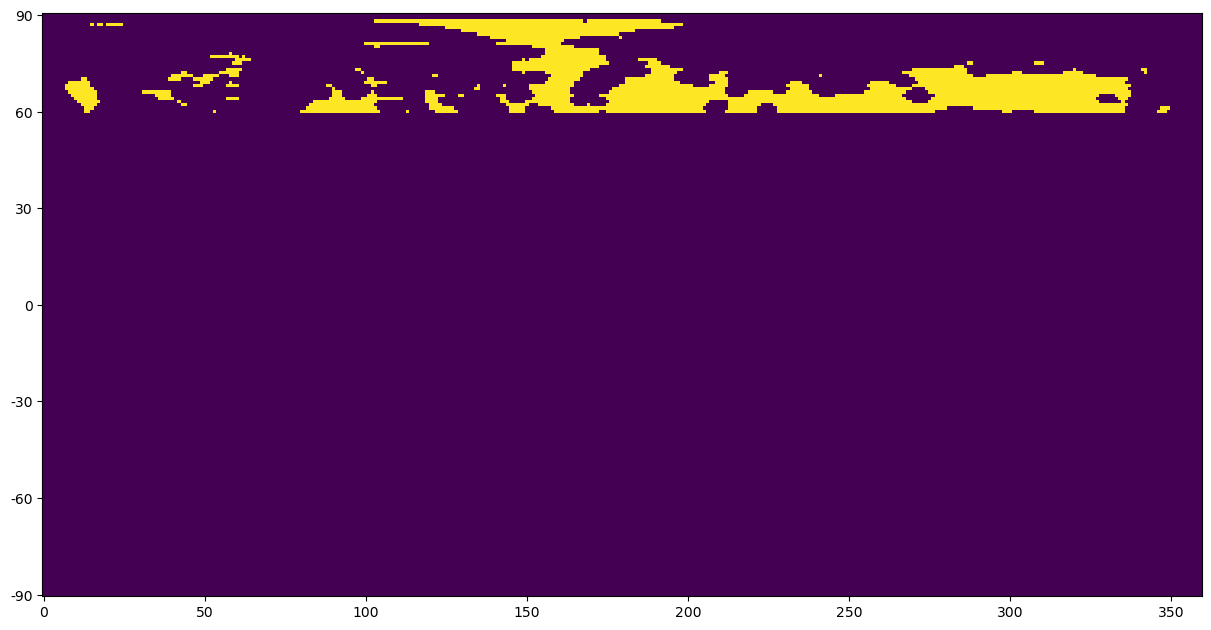

In [4]:
# MASK EXPLORING
# Nearly identical to 
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
#import matplotlib.pyplot as plt
#import matplotlib.animation as animation

#Ticks
latTicks = [0, 30, 60, 90, 120, 150, 180]
latLabels = ["90", "60", "30", "0", "-30", "-60", "-90"]

#set up the things that will hold it all.
X = 360 # 0 to 359, the 360th one being, of course, also 0. 
Y = 181 # +90 to -90
#only two dimensions. Lat and Lon.

allModels = [[0 for x in range(X)] for x in range(Y)] 
allModelsNum = [[0 for x in range(X)] for x in range(Y)] 

#allModels holds everything. 
#Read the data in, counting how many times we hit each bin.

flybyRangeAcceptable = False

with open(inputFile) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        lat = float(row[5])
        lon = float(row[6])
        #Convert to our map's indices.
        lat = 180 - (lat+90)
        lon = 360 - lon
        if (int(np.round(lon)) >= 360):
            lon = 0


        passedChecks = True #Unless something trips, this remains true.
        
        if (latLonCheck == True):
            if ((float(row[5]) > latLowerBound and float(row[5]) < latUpperBound and float(row[6]) > lonLowerBound and float(row[6]) < lonUpperBound) == False):
                passedChecks = False

        if (flybyCheck == True): #Are we in the right flyby range?
            if (flybyLowerBound == row[0]):
                flybyRangeAcceptable = True
            elif (flybyUpperBound == row[0]): #Note that upper flyby bound is not inclusive. 
                flybyRangeAcceptable = False
        else: 
            flybyRangeAcceptable = True #If we're not checking for time, all of them are fine. 
        if (flybyRangeAcceptable == False):
            passedChecks = False

        if (resolutionCheck == True):
            if ( (resUpperBound > float(row[10]) and resLowerBound < float(row[10]) and float(row[10]) != 0.0)== False ):
                passedChecks = False

        if (maskDistCheck == True):
            if (float(row[11]) < maskDistLimit):
                passedChecks = False

        if (maskDistResRelCheck == True):
            if ( float(row[10]) > maskDistRelLimit*float(row[11]) ):
                passedChecks = False     

        if (passedChecks == True):
            if (terrainType == "All"):
                if (ignoreNull == False):
                    allModels[int(np.round(lat))][int(np.round(lon))] = 1
                    allModelsNum[int(np.round(lat))][int(np.round(lon))] = allModelsNum[int(np.round(lat))][int(np.round(lon))] + 1
                elif (row[2] != "Null"):
                    allModels[int(np.round(lat))][int(np.round(lon))] = 1
                    allModelsNum[int(np.round(lat))][int(np.round(lon))] = allModelsNum[int(np.round(lat))][int(np.round(lon))] + 1
            elif (row[2] == terrainType):
                allModels[int(np.round(lat))][int(np.round(lon))] = 1
                allModelsNum[int(np.round(lat))][int(np.round(lon))] = allModelsNum[int(np.round(lat))][int(np.round(lon))] + 1
        line_count += 1

fig, ax = plt.subplots(figsize = (12,9),layout="constrained")
image = ax.imshow(allModels)
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)        
#print(allModels)

[Text(0, 0, '90'),
 Text(0, 30, '60'),
 Text(0, 60, '30'),
 Text(0, 90, '0'),
 Text(0, 120, '-30'),
 Text(0, 150, '-60'),
 Text(0, 180, '-90')]

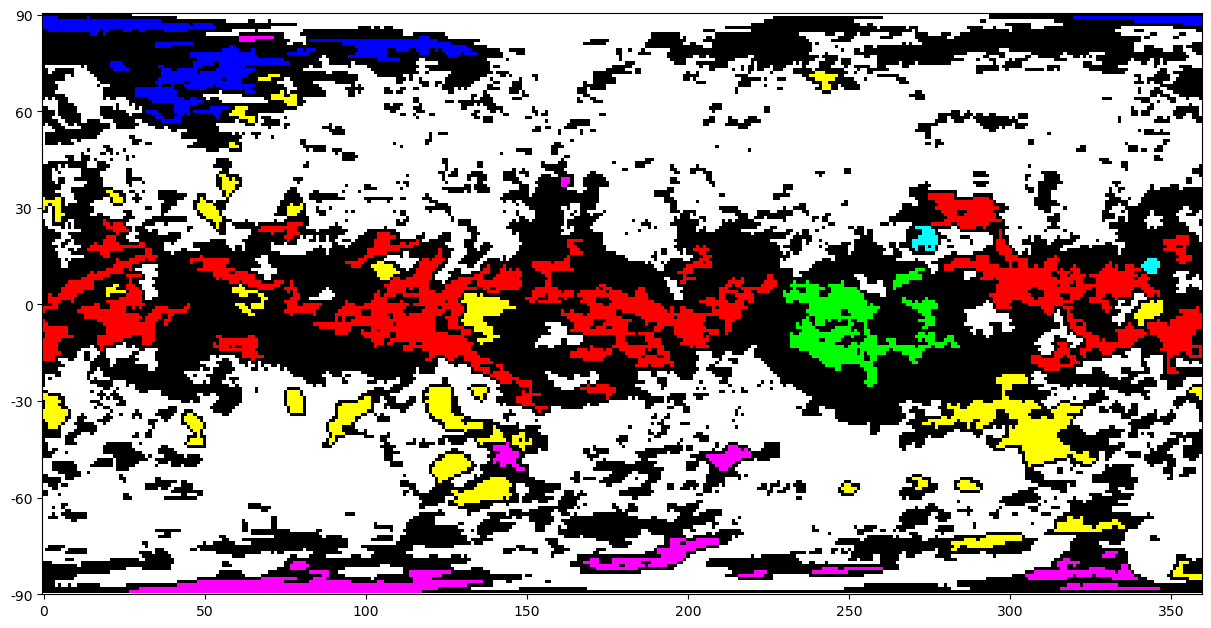

In [63]:
#For quick comparison:

tester = np.load("CLRMaskArray.npy")

plt.close()
fig, ax = plt.subplots(figsize = (12,9),layout="constrained")
image = ax.imshow(tester)
ax.set_yticks(latTicks)
ax.set_yticklabels(latLabels)

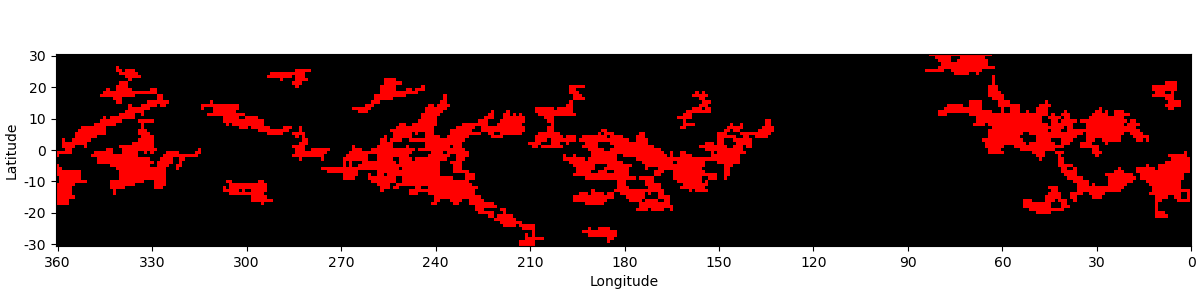

In [22]:
%matplotlib ipympl

#Displays the Mask without Distance/Confidence
tester = np.load("CLRMaskArray.npy")
mask = (tester[:, :, 1] != 0) | (tester[:, :, 2] != 0) | (tester[:, :, 0] == 0)
tester[mask] = [0,0,0]
center_slice = tester[60:121,:,:]

plt.close()
fig, ax = plt.subplots(figsize = (12,3),layout="constrained")
image = ax.imshow(center_slice)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(["30", "20", "10", "0", "-10", "-20", "-30"])
ax.set_ylabel("Latitude")
ax.set_xticks(lonTicks)
ax.set_xticklabels(lonLabels)
ax.set_xlabel("Longitude")
ax.set_facecolor("black")
#ax.set(title = "Titan Surface Terrain Mask")

plt.savefig("TitanSurfaceMaskDunes.pdf", format="pdf", bbox_inches='tight')
